<img align="right" width="30%"  src="https://upload.wikimedia.org/wikipedia/commons/d/d4/Thomas_Bayes.gif">

# Bayesian Inference Part 2: Hierarchical models & Confidence/credible Intervals

## ISM*@ST
Erik Tollerud


As a reminder: Bayesian fundamentals were discussed in [Session 1](Session%201.ipynb). I'll be following notational conventions from there, so if you get confused by anything that might help you out.

In [1]:
# will be helpful later, I promise

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from graphviz import Digraph

# Bayesian Heirarchical Modeling

#### What is that Word Salad I just said?

* A statistical model that has multiple "levels".   

Too circular, try again?

* If you have a likelihood that depends on two parameter sets $\Theta$ and $\Phi$, and the prior of one can be defined as:

 ${\color{blue}{P(\Theta, \Phi|M)}} = P(\Theta | \Phi)P(\Phi)$ 

  (On the RHS I dropped the $|M$ because it's everywhere.) Usually also the likelihood only depends explicitly on the bottom of the "heirarchy" $\Theta$ : $\color{green}{P(D| \Theta)}$, not $P(D| \Theta, \Phi)$.


Yeah, so... That doesn't really help, does it?  Lets try a concrete example.

Suppose you have a photon-counter with perfect (or at least perfectly-calibrated) efficiency logged every second that you run for a minute. This is a Poisson process, which is conveniently a single-parameter statistical distribution. That's a conscptually easy problem, so it gives us a chance to introduce the concept of graphical models:

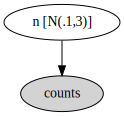

In [2]:
photon_counter = Digraph()
photon_counter.node('Like', 'counts', style="filled")
photon_counter.node('n', 'n [N(.1,3)]')
photon_counter.edge('n', 'Like')
photon_counter

This might seem silly right now, but it quickly becomes useful...

So how do we infer this trivial model? We just neet to give a single prior - lets see how that plays out:

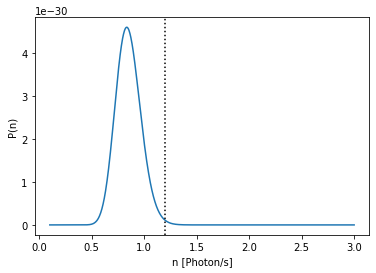

In [3]:
count_rate = 1.2 # per second
ps = np.random.poisson(count_rate, size=60)
# assume a uniform prior:
rate = np.linspace(.1, 3, 1000).reshape(1000,1)
logprobs = np.sum(stats.poisson.logpmf(ps, rate), axis=1)

plt.plot(rate, np.exp(logprobs))
plt.axvline(count_rate, color='k', ls=':')
plt.xlabel('n [Photon/s]')
plt.ylabel('P(n)');

But where did I get that prior from?  And why do I care, about the rate itself anyway?

What if instead my photon counter is counts from a star and I know I'm observing in g-band, and there are shallower observations in V and B?  Then I have a guess at the spectral slope/type, and a flux, but the uncertainties aren't in *my* band's flux. I can express my prior then as the best-guess spectrum combined with the V-band flux, and that fully describes my prior, but it's no trivial distribution in my g-band $n$.

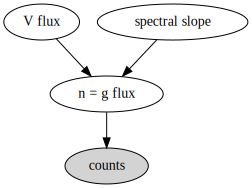

In [4]:
photon_counter_h = Digraph()
photon_counter_h.node('Like', 'counts', style="filled")
photon_counter_h.node('n', 'n = g flux')
photon_counter_h.node('V', 'V flux')
photon_counter_h.node('s', 'spectral slope')
photon_counter_h.edge('n', 'Like')
photon_counter_h.edge('V', 'n')
photon_counter_h.edge('s', 'n')
photon_counter_h

Now we end up with *3* possible output variables, even though the input data are the same.  But it's actually a *different answer* for n in the end, in addition to answering the *real* question we wanted (the stellar flux.

(Actually going through this example is an exercise for the reader!)

Note that the  real power of all this becomes clear when you have some part of it be "physical", even if you have to trade off by adding more complex heirarchical levels:

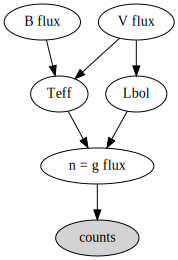

In [5]:
photon_counter_h = Digraph()
photon_counter_h.node('Like', 'counts', style="filled")
photon_counter_h.node('n', 'n = g flux')
photon_counter_h.node('V', 'V flux')
photon_counter_h.node('B', 'B flux')
photon_counter_h.node('teff', 'Teff')
photon_counter_h.node('l', 'Lbol')
photon_counter_h.edge('n', 'Like')
photon_counter_h.edge('V', 'teff')
photon_counter_h.edge('B', 'teff')
photon_counter_h.edge('V', 'l')
photon_counter_h.edge('teff', 'n')
photon_counter_h.edge('l', 'n')
photon_counter_h

Keep in mind though: this also illustrates that the top-level is subjective, so *everything* is a heirarchical model - you need at least *one* level with some sort of physical interpretation.  Formally it needs two levels to be heirarchical, but that's just silly IMHO.


On the same token, it'simportant to undestand that arbitrarily complex models can show up in diverse scientific settings:

![image](wang_model.png)

Neural networks for machine learning: https://doi.org/10.1109/TNN.2007.891186

Heirarchical models like this can get arbitrarily complicated:
![image](fleming_model.png)

Psychology of how people make decisions: https://doi.org/10.1093/nc/nix007

![image](foil_model.jpg)

High altitude human population convergent evolution: https://www.biorxiv.org/content/10.1101/002816v2.article-info

This is really Just meant to illustrate the diversity.  In practice astronomy models tend to be a fair bit simpler because we love us our power laws.  Or more to the point, we tend to have almost exclusively continuous physical models, which make our data more flexible, but bore the statisticians so they go have parties with biologists instead.

## Next Steps

1. Do the exercise outlined above!  I.e., use `emcee` to infer n, V flux, and a spectral slope given a dataset you make up.  Compare what you get for $n$ with the heirarchical model to a simpler uniform model like that I demonstrate above.

2. Try the exercise above, but use it with *real* data. To do this luck up some stars that are in "photometric standard" lists from the BVRI era (e.g. [Landolt standard](https://iopscience.iop.org/article/10.1088/0004-6256/146/5/131)), and then go to the [SDSS navigate page](https://skyserver.sdss.org/dr16/en/tools/chart/navi.aspx) and find one of them that you can cross-identify.

3. If you did this  one in Session 1, build off of https://emcee.readthedocs.io/en/stable/tutorials/line/, interpret it in the context of a heirarchical modeling approach by using snippets like the above to create the relevant graphical model.  If you're feeling imaginative, work out how you might add a layer of heirarchy in addition to the one that's already there and see how it changes the results.

4. Find a simple dataset of your own and try to build a heirarchical model where the top levels are all *physical* parameters.

5. Read some resources:

  * A more in-depth set of "formal stats" lectures: https://astrostatistics.psu.edu/RLectures/hierarchical.pdf
  * A longer set of lecture notes: http://www.stat.cmu.edu/~brian/463-663/week10/Chapter%2009.pdf
  * A full book chapter - chapter 5 of http://www.stat.columbia.edu/~gelman/book/ (includes Python examples here: https://github.com/avehtari/BDA_py_demos/tree/master/demos_ch5)

# Confidence and credible intervals

For our second topic we will visit the Bayesian "equivalent" of confidence intervals, known as credible intervals.  This is an area where frequentism and Bayes interpretations differ quite substantially, sometimes with minor but other times with major consequences.


## Confidence Intervals

Frequentist "uncertainity in parameters" relies on the concept of confidence intervals. These are formally to be thought of as an interval that will contain a specific model parameter a certain fraction of the time (where that fraction is the "confidence level" - e.g. 95%). Note that this is *not* what we usually think of as an "uncertainty" - it relies on the frequentist philosophy that you can repeat an experiment many times to validate whetheryour confidence interval guess is correct.  That tends to lead to increasingly convoluted thinking feature double-negatives or a focus on multiple layers of "repeated" observations/experiments where none are actually going to occur in reality.


## Credible Intervals

The Bayesian credible interval is easier to understand mathematically: it is simply the range a parameter falls within at specified probability levels. Alternatively: the "x-axis" for two values of the "y-axis" in a 1D CDF plot. This simplicty relative to the frequentist interpretation comes from the fact that Bayesian inference relies on treating the parameters as probability distributions instead of being fixed values.

(0.6626908486170743, 1.0533415097358263)

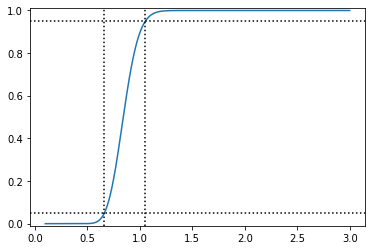

In [6]:
logprobs = np.sum(stats.poisson.logpmf(ps, rate), axis=1)
sumprob = np.cumsum(np.exp(logprobs))
sumprob /= sumprob[-1]

plt.plot(rate, sumprob)
lower_rate = np.interp(.05, sumprob, rate.ravel())
upper_rate = np.interp(.95, sumprob, rate.ravel())
plt.axhline(.05, c='k', ls=':')
plt.axhline(.95, c='k', ls=':')
plt.axvline(lower_rate, c='k', ls=':')
plt.axvline(upper_rate, c='k', ls=':')
plt.ylim(-0.01, 1.01)

lower_rate, upper_rate

Instead of spending a lot of time illustating this in more detail, I'm going to redirect further discussion here:

http://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/

which already says pretty much all of what I wanted to say! I suggest you read through it with a notebook or python interpreter open at the same time and run the examples yourself.

Once you've had a look at that, it's time to move on to exercises:

1. Look at the [COSfidence example](Session%202%20-%20COSfidence%20and%20Credibility%20Examples.ipynb) inspired by an earier ISM*@ST group meeting discussion
2. Examine any of the heirarchical models you did above, and compute credible intervals for some if the parameters.  Think about how you might work this in a frequentist confidence interval context (But if it takes a lot longer than the Credible Interval approach, that might be proving a useful point as well!)
3. Look over a paper of your own or possibly a friend/enemy or just some paper you find interesting that includes a confience interval. Can you tell what the statistical interpretation is meant to be?  Does it actually seem sensible in that context of the above discussion?